# Brazilian Chamber of Deputies 

The Open Data from Chamber service provides a collection of features that allow direct access to legislative data produced in the Chamber of Deputies, such as data on deputies, legislative bodies, proposals, plenary sessions, and committee meetings. 

There are two different ways to obtain this data. 

1. Through the available API, with `DadosAbertosBrasil` package developed by Gustavo Furtado or directly with `requests` package. 

2. Download `json` or `csv` formats from the website. 

Open data API website: https://dadosabertos.camara.leg.br/swagger/api.html#api

`DadosAbertosBrasil` package website: https://www.gustavofurtado.com/DadosAbertosBrasil/camara.html#documentacao-da-api-original

If necessary, install it.  

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import chisquare
import networkx as nx

from DadosAbertosBrasil import camara

import json
import time, tqdm

## Notebook settings 

In [4]:
api = "https://dadosabertos.camara.leg.br/api/v2/"

## Deputies

First we get the deputies list from the last legislature. 

In [3]:
deputies = camara.lista_deputados(legislatura = 56)
deputies.head()

,id,uri,nome,siglaPartido,uriPartido,siglaUf,idLegislatura,urlFoto,email
0,204554,https://dadosabertos.camara.leg.br/api/v2/depu...,Abílio Santana,PL,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,dep.abiliosantana@camara.leg.br
1,204521,https://dadosabertos.camara.leg.br/api/v2/depu...,Abou Anni,PSL,https://dadosabertos.camara.leg.br/api/v2/part...,SP,56,https://www.camara.leg.br/internet/deputado/ba...,dep.abouanni@camara.leg.br
2,204379,https://dadosabertos.camara.leg.br/api/v2/depu...,Acácio Favacho,PROS,https://dadosabertos.camara.leg.br/api/v2/part...,AP,56,https://www.camara.leg.br/internet/deputado/ba...,dep.acaciofavacho@camara.leg.br
3,204560,https://dadosabertos.camara.leg.br/api/v2/depu...,Adolfo Viana,PSDB,https://dadosabertos.camara.leg.br/api/v2/part...,BA,56,https://www.camara.leg.br/internet/deputado/ba...,dep.adolfoviana@camara.leg.br
4,204528,https://dadosabertos.camara.leg.br/api/v2/depu...,Adriana Ventura,NOVO,https://dadosabertos.camara.leg.br/api/v2/part...,SP,56,https://www.camara.leg.br/internet/deputado/ba...,dep.adrianaventura@camara.leg.br


## Votes in 2019 

For each voting, we can access how the deputies voted. 

In [ ]:
votacoes = camara.lista_votacoes(inicio='2019-02-01', pagina=1)

for page in tqdm.tqdm(range(44), position=0):
    time.sleep(10)
    for test in range(5): 
        try:
            votacoes = votacoes.append(camara.lista_votacoes(inicio='2019-02-01', pagina=page+1))
        except: 
            time.sleep(5)
            print('Page {} with problem. Trying again!'.format(page+1))

Usando a versão das votações em formato json.

In [5]:
with open('votacoes-2019.json') as f:
    votacoes_2019 = json.load(f)['dados']

In [6]:
votacoes_deputados = pd.DataFrame(np.nan,
                                  columns=deputados.id,
                                  index=[vote['id'] for vote in votacoes_2019]
                                 )

Computando votos

In [7]:
with open('votacoesVotos-2019.json') as f:
    votacoes_votos_2019 = json.load(f)['dados']

for voto in tqdm.tqdm(votacoes_votos_2019):
    votacoes_deputados.loc[voto['idVotacao'], int(voto['deputado_']['id'])] = 1*(voto['voto'] == 'Sim')

100%|██████████| 120952/120952 [00:10<00:00, 11944.04it/s]


In [8]:
votacoes_corr = votacoes_deputados.corr()

In [9]:
th = np.quantile(abs(votacoes_corr.fillna(0).values).flatten(), 
                 q = 0.6)

adj = 1*((abs(votacoes_corr) > th)&(votacoes_corr < 1))

Construindo grafo. 

In [10]:
G_deputados = nx.from_pandas_adjacency(adj)

nodes = {deputados['id'].iloc[i]:
          dict(partido = deputados['siglaPartido'].iloc[i], 
               estado = deputados['siglaUf'].iloc[i])
         for i in range(deputados.shape[0])}

nx.classes.function.set_node_attributes(G_deputados, nodes)

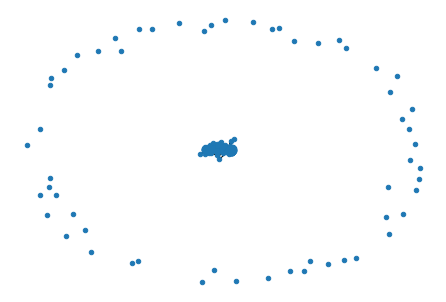

In [12]:
nx.draw(G_deputados, node_size = 20)